In [46]:
import numpy as np
import pickle
from tqdm import tqdm
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix,classification_report
import matplotlib.pyplot as plt
import random

In [47]:
# hyperparameters
num_classes = 10
# num_epochs = 10
# learning_rate = 0.001
# dropout_rate = 0.3
random_seed = 42

In [48]:

class DenseLayer:
    def __init__(self, output_size, input_size):
        
        # Xavier initialization
        limit = np.sqrt(6 / (input_size + output_size))
        self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        self.biases = np.zeros((1, output_size))
        self.input = None
        self.output = None
        self.dweights = None
        self.dbiases = None

    def forward(self, inputs):
        self.input = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, gradient):
        self.dweights = np.dot(self.input.T, gradient)
        self.dbiases = np.sum(gradient, axis=0, keepdims=True)
        return np.dot(gradient, self.weights.T)

In [49]:
class BatchNormalization:
    def __init__(self, input_size, epsilon=1e-8, momentum=0.99):
        self.gamma = np.ones((1, input_size))
        self.beta = np.zeros((1, input_size))
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = np.zeros((1, input_size))
        self.running_var = np.ones((1, input_size))
        self.input = None
        self.mean = None
        self.var = None
        self.normalized = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, inputs, training=True):
        self.input = inputs
        if training:
            self.mean = np.mean(inputs, axis=0, keepdims=True)
            self.var = np.var(inputs, axis=0, keepdims=True)
            self.normalized = (inputs - self.mean) / np.sqrt(self.var + self.epsilon)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.mean = self.running_mean
            self.var = self.running_var
            self.normalized = (inputs - self.mean) / np.sqrt(self.var + self.epsilon)
        return self.gamma * self.normalized + self.beta
    
    def backward(self, gradient):
        num = self.input.shape[0]
        self.dgamma = np.sum(gradient * self.normalized, axis=0, keepdims=True)
        self.dbeta = np.sum(gradient, axis=0, keepdims=True)
        dnormalized = gradient * self.gamma
        dvar = np.sum(dnormalized * (self.input - self.mean) * -0.5 * (self.var + self.epsilon) ** -1.5, axis=0, keepdims=True)
        dmean = np.sum(dnormalized * -1 / np.sqrt(self.var + self.epsilon), axis=0, keepdims=True) + dvar * np.mean(-2 * (self.input - self.mean), axis=0, keepdims=True)
        return dnormalized / np.sqrt(self.var + self.epsilon) + dvar * 2 * (self.input - self.mean) / num + dmean / num

In [50]:
class ReLU:
    def __init__(self):
        self.input = None

    def forward(self, inputs):
        self.input = inputs
        return np.maximum(0, inputs)

    def backward(self, gradient):
        return gradient * (self.input > 0)

In [51]:

class Sigmoid:
    def __init__(self):
        self.output = None

    def forward(self, inputs):
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

    def backward(self, gradient):
        return gradient * self.output * (1 - self.output)

In [52]:


class Tanh:
    def __init__(self):
        self.output = None

    def forward(self, inputs):
        self.output = np.tanh(inputs)
        return self.output

    def backward(self, gradient):
        return gradient * (1 - self.output**2)

In [53]:


class Dropout:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward(self, inputs, training=True):
        if training:
            self.mask = np.random.binomial(1, 1 - self.rate, inputs.shape) / (1 - self.rate)
            return inputs * self.mask
        return inputs

    def backward(self, gradient):
        return gradient * self.mask

In [54]:

class Softmax:
    def __init__(self):
        self.output = None

    def forward(self, inputs):
        exp = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp / np.sum(exp, axis=1, keepdims=True)
        return self.output

    def backward(self, gradient):
        return gradient * self.output * (1 - self.output)


In [55]:

class Adam:
    def __init__(self, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params, grads):
        self.t += 1
        for param_name in params:
            if param_name not in self.m:
                self.m[param_name] = np.zeros_like(params[param_name])
                self.v[param_name] = np.zeros_like(params[param_name])


            self.m[param_name] = self.beta1 * self.m[param_name] + (1 - self.beta1) * grads[param_name]
            self.v[param_name] = self.beta2 * self.v[param_name] + (1 - self.beta2) * (grads[param_name] ** 2)

            m_hat = self.m[param_name] / (1 - self.beta1 ** self.t)
            v_hat = self.v[param_name] / (1 - self.beta2 ** self.t)

            params[param_name] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [56]:
class AdamOptimizer():
    def __init__(self, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0
        self.layers = None

    def update(self, layers):

        self.layers = layers
        self.t += 1

        if self.m is None:
            self.m = {}
            self.v = {}
            for i,layer in enumerate(self.layers):
                class_name = layer.__class__.__name__

                if class_name == 'DenseLayer':
                    self.m[f'{class_name}_{i}_weigths'] = np.zeros_like(layer.weights)
                    self.v[f'{class_name}_{i}_weigths'] = np.zeros_like(layer.weights)
                    self.m[f'{class_name}_{i}_biases'] = np.zeros_like(layer.biases)
                    self.v[f'{class_name}_{i}_biases'] = np.zeros_like(layer.biases)
                    
                # elif class_name == 'BatchNormalization':
                #     self.m[f'{class_name}_{i}_gamma'] = np.zeros_like(layer.gamma)
                #     self.v[f'{class_name}_{i}_gamma'] = np.zeros_like(layer.gamma)
                #     self.m[f'{class_name}_{i}_beta'] = np.zeros_like(layer.beta)
                #     self.v[f'{class_name}_{i}_beta'] = np.zeros_like(layer.beta)

        for i,layer in enumerate(self.layers):
            class_name = layer.__class__.__name__

            if class_name == 'DenseLayer':
                self.m[f'{class_name}_{i}_weigths'] = self.beta1 * self.m[f'{class_name}_{i}_weigths'] + (1 - self.beta1) * layer.dweights
                self.v[f'{class_name}_{i}_weigths'] = self.beta2 * self.v[f'{class_name}_{i}_weigths'] + (1 - self.beta2) * np.square(layer.dweights)
                m_hat = self.m[f'{class_name}_{i}_weigths'] / (1 - self.beta1 ** self.t)
                v_hat = self.v[f'{class_name}_{i}_weigths'] / (1 - self.beta2 ** self.t)
                layer.weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

                self.m[f'{class_name}_{i}_biases'] = self.beta1 * self.m[f'{class_name}_{i}_biases'] + (1 - self.beta1) * layer.dbiases
                self.v[f'{class_name}_{i}_biases'] = self.beta2 * self.v[f'{class_name}_{i}_biases'] + (1 - self.beta2) * np.square(layer.dbiases)
                m_hat = self.m[f'{class_name}_{i}_biases'] / (1 - self.beta1 ** self.t)
                v_hat = self.v[f'{class_name}_{i}_biases'] / (1 - self.beta2 ** self.t)
                layer.biases -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            # elif class_name == 'BatchNormalization':
            #     self.m[f'{class_name}_{i}_gamma'] = self.beta1 * self.m[f'{class_name}_{i}_gamma'] + (1 - self.beta1) * layer.dgamma
            #     self.v[f'{class_name}_{i}_gamma'] = self.beta2 * self.v[f'{class_name}_{i}_gamma'] + (1 - self.beta2) * (layer.dgamma ** 2)
            #     m_hat = self.m[f'{class_name}_{i}_gamma'] / (1 - self.beta1 ** self.t)
            #     v_hat = self.v[f'{class_name}_{i}_gamma'] / (1 - self.beta2 ** self.t)

            #     layer.gamma -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            #     self.m[f'{class_name}_{i}_beta'] = self.beta1 * self.m[f'{class_name}_{i}_beta'] + (1 - self.beta1) * layer.dbeta
            #     self.v[f'{class_name}_{i}_beta'] = self.beta2 * self.v[f'{class_name}_{i}_beta'] + (1 - self.beta2) * (layer.dbeta ** 2)
            #     m_hat = self.m[f'{class_name}_{i}_beta'] / (1 - self.beta1 ** self.t)
            #     v_hat = self.v[f'{class_name}_{i}_beta'] / (1 - self.beta2 ** self.t)

            #     layer.beta -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [57]:
def shuffle_data(X, y):
    indices = np.random.permutation(X.shape[0])
    return X[indices], y[indices]

In [58]:
class NeuralNetwork:
    def __init__(self,learning_rate=0.001):
        self.layers = []
        # self.optimizer = Adam(learning_rate=learning_rate)
        self.optimizer = AdamOptimizer(learning_rate=learning_rate)

    def add(self, layer):
        self.layers.append(layer)
    
    def forward(self, inputs, training=True):
        for layer in self.layers:
            # if the layer is a Dropout or BatchNormalization layer, pass the training flag to the forward method
            if isinstance(layer, (Dropout, BatchNormalization)):
                inputs = layer.forward(inputs, training)
            else:
                inputs = layer.forward(inputs)
        return inputs

    def backward(self, gradient):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def train(self, epochs, batch_size, X, y, X_val=None, y_val=None, early_stopping=True, patience=2):
        num_samples = X.shape[0]
        num_batches = num_samples // batch_size
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

        best_val_loss = np.inf
        patience_counter = 0

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            epoch_loss = 0
            epoch_acc = 0
            # Shuffle the data
            X, y = shuffle_data(X, y)

            for batch in tqdm(range(num_batches)):
                start = batch * batch_size
                end = start + batch_size
                X_batch = X[start:end]
                y_batch = y[start:end]

                # Forward pass
                y_pred = self.forward(X_batch)
                loss = -np.sum(y_batch * np.log(y_pred + 1e-8)) / batch_size
                acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))

                # Backward pass
                gradient = (y_pred - y_batch) / batch_size
                self.backward(gradient)

                # Update weights and biases
                self.optimizer.update(self.layers)

                epoch_loss += loss
                epoch_acc += acc

            epoch_loss /= num_batches
            epoch_acc /= num_batches
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc)

            print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

            if X_val is not None and y_val is not None:
                
                # X_val, y_val = shuffle_data(X_val, y_val)
                val_pred = self.forward(X_val, training=False)
                val_loss = -np.sum(y_val * np.log(val_pred + 1e-8)) / X_val.shape[0]
                val_acc = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1))
                val_f1 =  f1_score(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1), average='macro')
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['val_f1'].append(val_f1)
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

                # Early stopping
                if early_stopping:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                    else:
                        patience_counter += 1
                    if patience_counter>= patience:
                        print(f"Early stopping at epoch {epoch + 1}")
                        break

        return history
    
    def predict(self, X):
        return self.forward(X, training=False)

    def save(self, filename):
        # save everything that is needed to recreate the model
        weights_biases = {'weights': {}, 'biases': {}}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights'):
                weights_biases['weights'][f'{layer.__class__.__name__}_{i}_weights'] = layer.weights
                weights_biases['biases'][f'{layer.__class__.__name__}_{i}_biases'] = layer.biases
        with open(filename, 'wb') as f:
            pickle.dump(weights_biases, f)

    @staticmethod
    def load(filename, model=None):
        with open(filename, 'rb') as f:
            weights_biases = pickle.load(f)
            # print(weights_biases)
            
        if model is None:
            raise ValueError("Model is not defined")
        
        for i, layer in enumerate(model.layers):
            if hasattr(layer, 'weights'):
                layer.weights = weights_biases['weights'][f'{layer.__class__.__name__}_{i}_weights']
                layer.biases = weights_biases['biases'][f'{layer.__class__.__name__}_{i}_biases']
        return model
    
    def __str__(self):
        # print the architecture of the model with input and output shape and number of parameters
        model_summary = ""
        for i, layer in enumerate(self.layers):
            if i == 0:
                model_summary += f"Input shape: {layer.weights.shape[0]}\n"
            if hasattr(layer, 'weights'):
                model_summary += f"{layer.__class__.__name__} - Output shape: {layer.weights.shape[1]}, Number of parameters: {layer.weights.size + layer.biases.size}\n"
            else:
                model_summary += f"{layer.__class__.__name__}\n"
        return model_summary
    
    def __repr__(self):
        return self.__str__()


In [59]:

# Data loading and preprocessing
def load_fashion_mnist():
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    
    # print(train_dataset.data.shape)
    # print(test_dataset.data.shape)

    # Converts the training images to a NumPy array
    # Flattens each 28x28 image into a 784-element vector
    # Normalizes the pixel values in the range [0, 1] 
    X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
    # One-hot encoding
    y_train = np.eye(num_classes)[train_dataset.targets.numpy()]  # np.eye(10) creates an identity matrix of size 10x10
    X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
    y_test = np.eye(num_classes)[test_dataset.targets.numpy()]

    return X_train, y_train, X_test, y_test

In [60]:
# Visualization functions
def plot_history(history):
    # plot the training and validation loss, accuracy and validation f1-score
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

In [61]:
import itertools
# plot confusion matrix with % value
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Model 1

In [62]:
def create_model_1(learning_rate=0.005,dropout_rate=0.2,num_classes=10): 
    model = NeuralNetwork(learning_rate=learning_rate)
    model.add(DenseLayer(512, 28*28))
    model.add(BatchNormalization(512))
    model.add(ReLU())
    model.add(Dropout(dropout_rate))
    model.add(DenseLayer(num_classes, 512))
    model.add(Softmax())
    return model

In [63]:
def create_model_2(learning_rate,dropout_rate,num_classes): 
    model = NeuralNetwork(learning_rate=learning_rate)
    model.add(DenseLayer(256, 28*28))
    model.add(BatchNormalization(256))
    model.add(ReLU())
    model.add(Dropout(dropout_rate))
    model.add(DenseLayer(num_classes, 256))
    model.add(Softmax())
    return model

In [64]:
def create_model_3(learning_rate,dropout_rate,num_classes): 
    model = NeuralNetwork(learning_rate=learning_rate)
    model.add(DenseLayer(512, 28*28))
    model.add(BatchNormalization(512))
    model.add(ReLU())
    model.add(Dropout(dropout_rate))
    model.add(DenseLayer(256, 512))
    model.add(BatchNormalization(256))
    model.add(ReLU())
    model.add(Dropout(dropout_rate))
    model.add(DenseLayer(num_classes, 256))
    model.add(Softmax())
    return model

In [65]:
def run_diff_model(model_name,learning_rate,dropout_rate,num_classes,num_epochs,batch_size):
    
    report_filename = f'./reports/{model_name}_report_lr_{learning_rate}.txt'
    model_filename = f'./models/{model_name}_lr_{learning_rate}.pkl'
    print_report = True
    print(f"Running {model_name} model with learning rate {learning_rate} and dropout rate {dropout_rate}")

    MODEL_NUM = model_name.split('_')[1]
    X_train, y_train, X_test, y_test = load_fashion_mnist()

    # Split the training data into training and validation sets
    validation_split = 0.2 # 80% training, 20% validation
    split = int((1 - validation_split) * X_train.shape[0])
    X_train, X_val = X_train[:split], X_train[split:]
    y_train, y_val = y_train[:split], y_train[split:]


    if MODEL_NUM == '1':
        model = create_model_1(learning_rate,dropout_rate,num_classes)
    elif MODEL_NUM == '2':
        model = create_model_2(learning_rate,dropout_rate,num_classes)
    else:
        model = create_model_3(learning_rate,dropout_rate,num_classes)
    
    history = model.train(num_epochs, batch_size, X_train, y_train, X_val, y_val)
    
    plot_history(history)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    test_acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), class_names)
 
    if print_report:
        # if the report file does not exist, create it and write the header
        with open(report_filename, "w") as f:
            f.write('Fashion MNIST Classification Report\n\n')
            f.write(f'Model: {model_name}\n')
            f.write(f'Learning Rate: {learning_rate}\n')
            f.write(f'Dropout Rate: {dropout_rate}\n')
            f.write(f'Batch Size: {batch_size}\n')
            f.write(f'Number of Epochs: {num_epochs}\n\n')
            f.write('Classification Report\n')
            f.write(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=class_names))
            f.write(f'Test Accuracy: {test_acc:.4f}\n')
            f.write(f'Test F1 Score: {test_f1:.4f}\n')
        print(f"Classification report saved to {report_filename}")

    # Save the model
    model.save(model_filename)
    


In [66]:
learning_rates = [0.005,0.005/2,0.005/4,0.005/8]

Running model_1 model with learning rate 0.005 and dropout rate 0.2
Epoch 1/15


100%|██████████| 46/46 [00:08<00:00,  5.15it/s]


Train Loss: 0.6909, Train Acc: 0.7770
Val Loss: 0.6714, Val Acc: 0.7963, Val F1: 0.7915
Epoch 2/15


100%|██████████| 46/46 [00:07<00:00,  6.07it/s]


Train Loss: 0.4525, Train Acc: 0.8494
Val Loss: 0.5603, Val Acc: 0.8302, Val F1: 0.8178
Epoch 3/15


100%|██████████| 46/46 [00:07<00:00,  6.34it/s]


Train Loss: 0.3994, Train Acc: 0.8687
Val Loss: 0.4504, Val Acc: 0.8532, Val F1: 0.8496
Epoch 4/15


100%|██████████| 46/46 [00:07<00:00,  6.24it/s]


Train Loss: 0.3794, Train Acc: 0.8764
Val Loss: 0.4414, Val Acc: 0.8547, Val F1: 0.8480
Epoch 5/15


100%|██████████| 46/46 [00:07<00:00,  6.25it/s]


Train Loss: 0.3740, Train Acc: 0.8816
Val Loss: 0.6704, Val Acc: 0.7967, Val F1: 0.7942
Epoch 6/15


100%|██████████| 46/46 [00:07<00:00,  6.01it/s]


Train Loss: 0.3855, Train Acc: 0.8815
Val Loss: 1.0803, Val Acc: 0.7301, Val F1: 0.7046
Early stopping at epoch 6


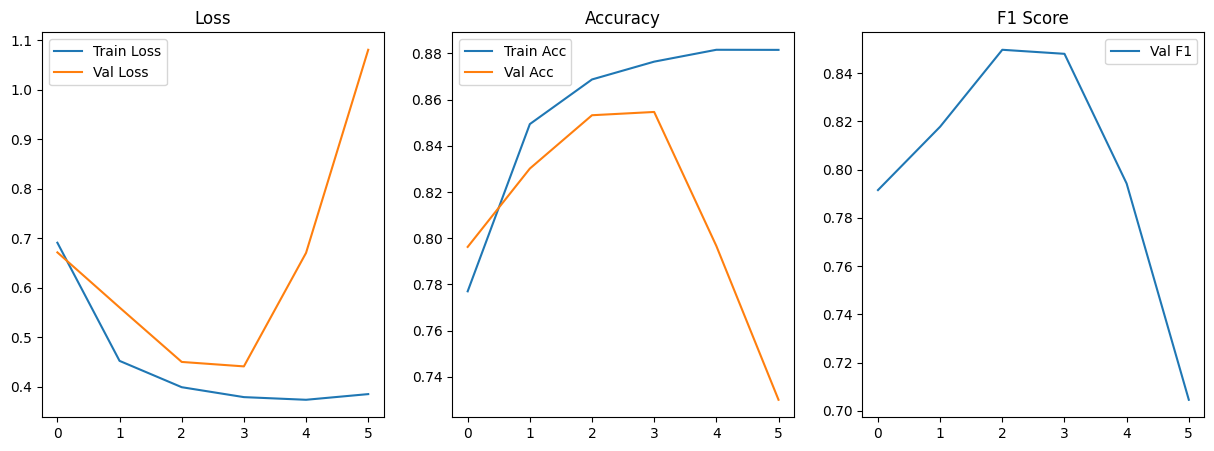

Test Accuracy: 0.7232
Test F1 Score: 0.6978


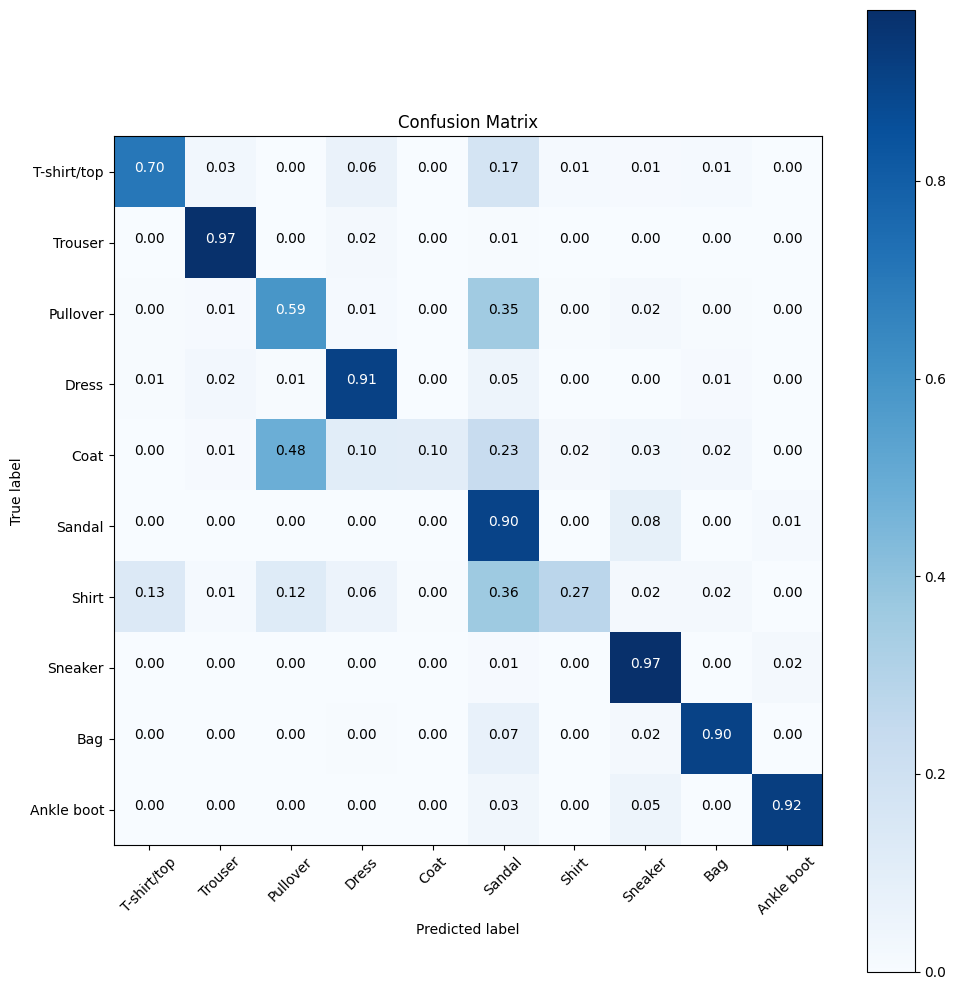

Classification report saved to ./reports/model_1_report_lr_0.005.txt
Running model_1 model with learning rate 0.0025 and dropout rate 0.2
Epoch 1/15


100%|██████████| 46/46 [00:08<00:00,  5.62it/s]


Train Loss: 0.6516, Train Acc: 0.7836
Val Loss: 0.6573, Val Acc: 0.7750, Val F1: 0.7605
Epoch 2/15


100%|██████████| 46/46 [00:09<00:00,  4.94it/s]


Train Loss: 0.4241, Train Acc: 0.8565
Val Loss: 0.4888, Val Acc: 0.8348, Val F1: 0.8336
Epoch 3/15


100%|██████████| 46/46 [00:10<00:00,  4.32it/s]


Train Loss: 0.3916, Train Acc: 0.8687
Val Loss: 0.4164, Val Acc: 0.8610, Val F1: 0.8621
Epoch 4/15


100%|██████████| 46/46 [00:09<00:00,  4.67it/s]


Train Loss: 0.3571, Train Acc: 0.8811
Val Loss: 0.3867, Val Acc: 0.8695, Val F1: 0.8634
Epoch 5/15


100%|██████████| 46/46 [00:10<00:00,  4.44it/s]


Train Loss: 0.3366, Train Acc: 0.8897
Val Loss: 0.3729, Val Acc: 0.8732, Val F1: 0.8702
Epoch 6/15


100%|██████████| 46/46 [00:10<00:00,  4.40it/s]


Train Loss: 0.3186, Train Acc: 0.8950
Val Loss: 0.3956, Val Acc: 0.8642, Val F1: 0.8630
Epoch 7/15


100%|██████████| 46/46 [00:10<00:00,  4.21it/s]


Train Loss: 0.3072, Train Acc: 0.8994
Val Loss: 0.3566, Val Acc: 0.8774, Val F1: 0.8774
Epoch 8/15


100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


Train Loss: 0.2966, Train Acc: 0.9055
Val Loss: 0.3889, Val Acc: 0.8618, Val F1: 0.8603
Epoch 9/15


100%|██████████| 46/46 [00:10<00:00,  4.52it/s]


Train Loss: 0.2870, Train Acc: 0.9079
Val Loss: 0.3953, Val Acc: 0.8676, Val F1: 0.8603
Early stopping at epoch 9


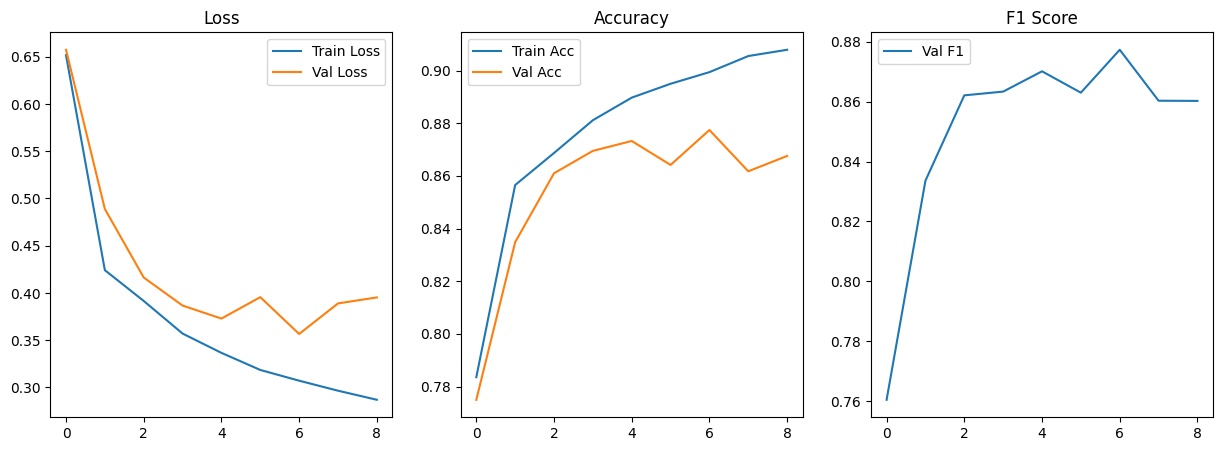

Test Accuracy: 0.8569
Test F1 Score: 0.8494


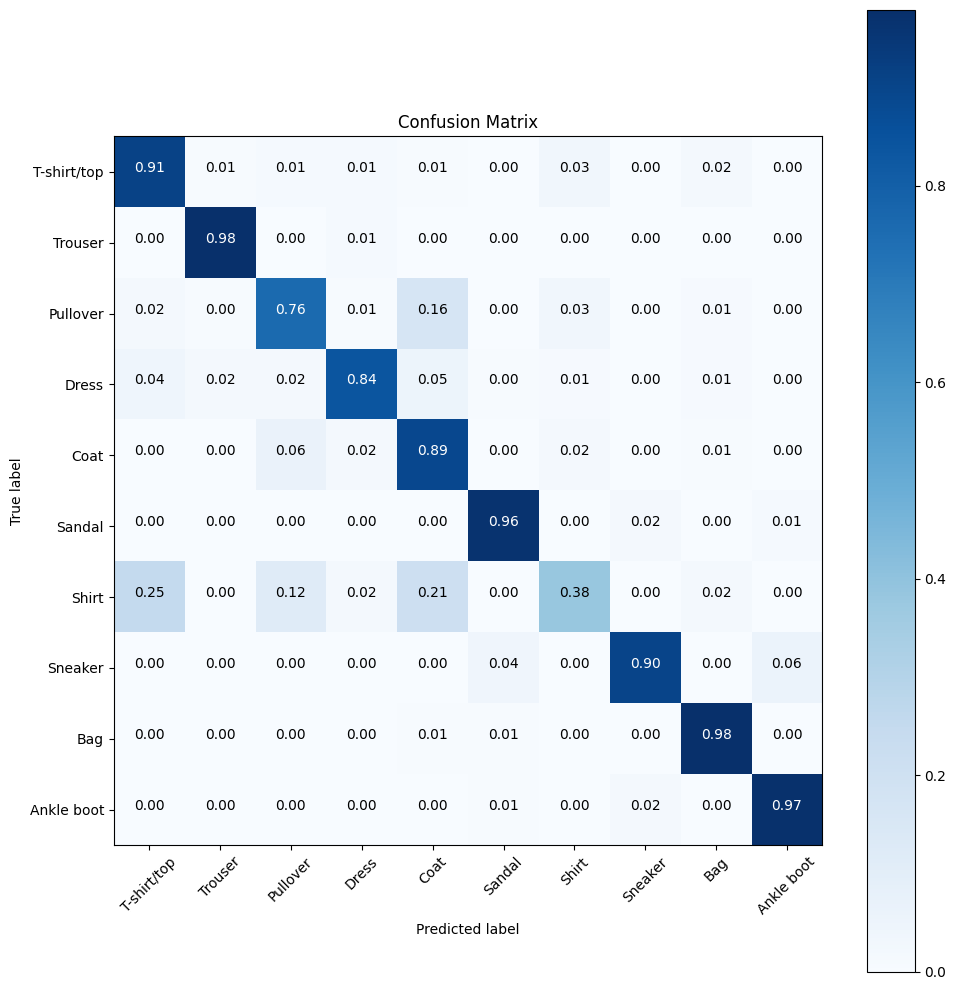

Classification report saved to ./reports/model_1_report_lr_0.0025.txt
Running model_1 model with learning rate 0.00125 and dropout rate 0.2
Epoch 1/15


100%|██████████| 46/46 [00:09<00:00,  4.83it/s]


Train Loss: 0.6473, Train Acc: 0.7806
Val Loss: 0.7270, Val Acc: 0.7974, Val F1: 0.7944
Epoch 2/15


100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


Train Loss: 0.4106, Train Acc: 0.8606
Val Loss: 0.5221, Val Acc: 0.8423, Val F1: 0.8360
Epoch 3/15


100%|██████████| 46/46 [00:10<00:00,  4.50it/s]


Train Loss: 0.3722, Train Acc: 0.8754
Val Loss: 0.5018, Val Acc: 0.8356, Val F1: 0.8323
Epoch 4/15


100%|██████████| 46/46 [00:08<00:00,  5.44it/s]


Train Loss: 0.3508, Train Acc: 0.8838
Val Loss: 0.4113, Val Acc: 0.8658, Val F1: 0.8667
Epoch 5/15


100%|██████████| 46/46 [00:09<00:00,  4.99it/s]


Train Loss: 0.3271, Train Acc: 0.8916
Val Loss: 0.3979, Val Acc: 0.8591, Val F1: 0.8549
Epoch 6/15


100%|██████████| 46/46 [00:07<00:00,  6.09it/s]


Train Loss: 0.3104, Train Acc: 0.8985
Val Loss: 0.3651, Val Acc: 0.8802, Val F1: 0.8795
Epoch 7/15


100%|██████████| 46/46 [00:08<00:00,  5.55it/s]


Train Loss: 0.2989, Train Acc: 0.9022
Val Loss: 0.3799, Val Acc: 0.8654, Val F1: 0.8640
Epoch 8/15


100%|██████████| 46/46 [00:09<00:00,  5.05it/s]


Train Loss: 0.2857, Train Acc: 0.9070
Val Loss: 0.3474, Val Acc: 0.8822, Val F1: 0.8804
Epoch 9/15


100%|██████████| 46/46 [00:08<00:00,  5.49it/s]


Train Loss: 0.2752, Train Acc: 0.9106
Val Loss: 0.3659, Val Acc: 0.8700, Val F1: 0.8718
Epoch 10/15


100%|██████████| 46/46 [00:08<00:00,  5.48it/s]


Train Loss: 0.2671, Train Acc: 0.9147
Val Loss: 0.3273, Val Acc: 0.8868, Val F1: 0.8863
Epoch 11/15


100%|██████████| 46/46 [00:08<00:00,  5.46it/s]


Train Loss: 0.2582, Train Acc: 0.9181
Val Loss: 0.3439, Val Acc: 0.8811, Val F1: 0.8815
Epoch 12/15


100%|██████████| 46/46 [00:08<00:00,  5.32it/s]


Train Loss: 0.2519, Train Acc: 0.9219
Val Loss: 0.3495, Val Acc: 0.8808, Val F1: 0.8810
Early stopping at epoch 12


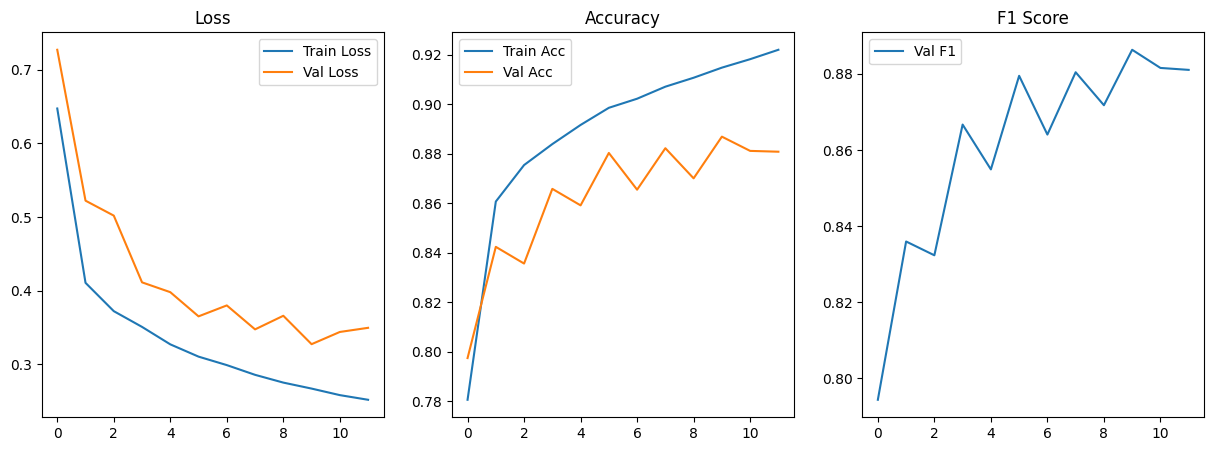

Test Accuracy: 0.8733
Test F1 Score: 0.8736


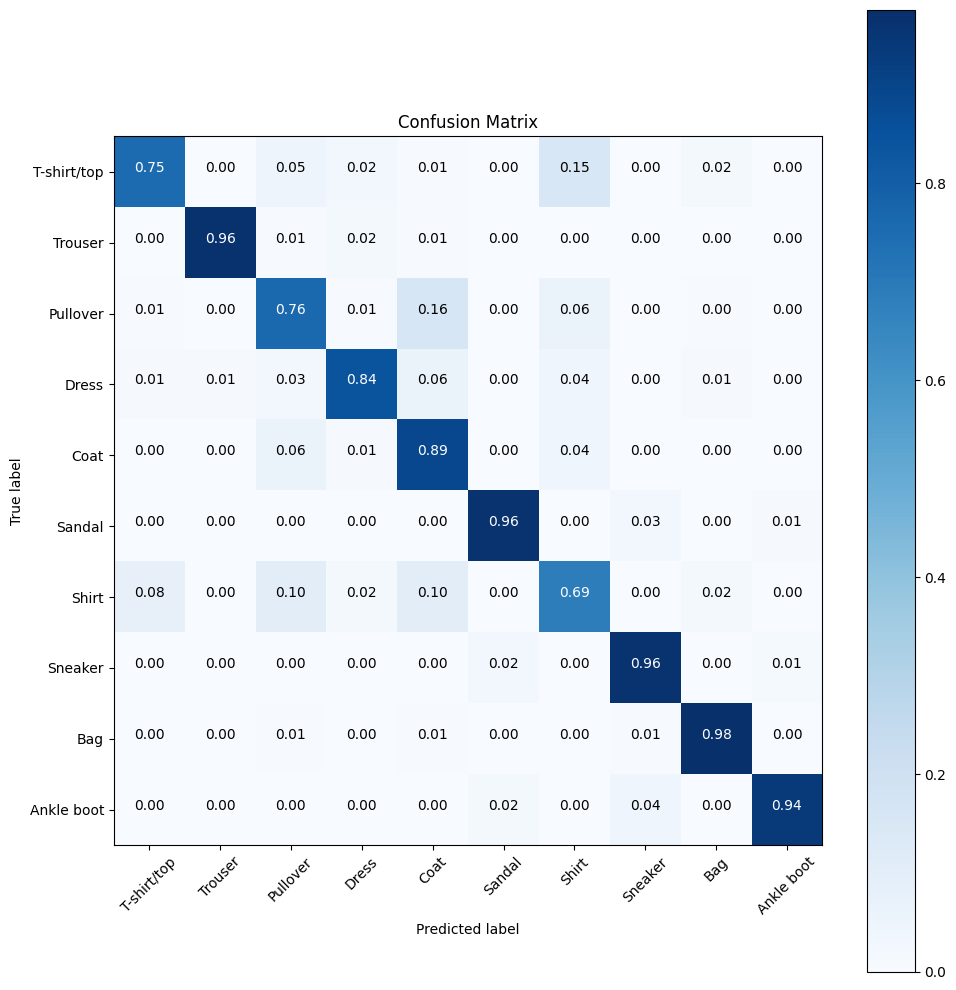

Classification report saved to ./reports/model_1_report_lr_0.00125.txt
Running model_1 model with learning rate 0.000625 and dropout rate 0.2
Epoch 1/15


100%|██████████| 46/46 [00:08<00:00,  5.29it/s]


Train Loss: 0.7194, Train Acc: 0.7588
Val Loss: 0.9009, Val Acc: 0.7531, Val F1: 0.7512
Epoch 2/15


100%|██████████| 46/46 [00:09<00:00,  5.07it/s]


Train Loss: 0.4400, Train Acc: 0.8507
Val Loss: 0.6624, Val Acc: 0.8219, Val F1: 0.8229
Epoch 3/15


100%|██████████| 46/46 [00:08<00:00,  5.46it/s]


Train Loss: 0.3955, Train Acc: 0.8676
Val Loss: 0.5282, Val Acc: 0.8550, Val F1: 0.8513
Epoch 4/15


100%|██████████| 46/46 [00:09<00:00,  5.06it/s]


Train Loss: 0.3668, Train Acc: 0.8781
Val Loss: 0.4347, Val Acc: 0.8728, Val F1: 0.8711
Epoch 5/15


100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


Train Loss: 0.3478, Train Acc: 0.8863
Val Loss: 0.4084, Val Acc: 0.8728, Val F1: 0.8699
Epoch 6/15


100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


Train Loss: 0.3327, Train Acc: 0.8899
Val Loss: 0.3726, Val Acc: 0.8798, Val F1: 0.8787
Epoch 7/15


100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


Train Loss: 0.3200, Train Acc: 0.8968
Val Loss: 0.4000, Val Acc: 0.8613, Val F1: 0.8625
Epoch 8/15


100%|██████████| 46/46 [00:10<00:00,  4.35it/s]


Train Loss: 0.3069, Train Acc: 0.9006
Val Loss: 0.3698, Val Acc: 0.8719, Val F1: 0.8684
Epoch 9/15


100%|██████████| 46/46 [00:08<00:00,  5.13it/s]


Train Loss: 0.2953, Train Acc: 0.9055
Val Loss: 0.3494, Val Acc: 0.8812, Val F1: 0.8786
Epoch 10/15


100%|██████████| 46/46 [00:08<00:00,  5.16it/s]


Train Loss: 0.2843, Train Acc: 0.9110
Val Loss: 0.3577, Val Acc: 0.8738, Val F1: 0.8730
Epoch 11/15


100%|██████████| 46/46 [00:08<00:00,  5.27it/s]


Train Loss: 0.2781, Train Acc: 0.9128
Val Loss: 0.3351, Val Acc: 0.8832, Val F1: 0.8819
Epoch 12/15


100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


Train Loss: 0.2704, Train Acc: 0.9157
Val Loss: 0.3312, Val Acc: 0.8849, Val F1: 0.8842
Epoch 13/15


100%|██████████| 46/46 [00:11<00:00,  4.01it/s]


Train Loss: 0.2619, Train Acc: 0.9190
Val Loss: 0.3617, Val Acc: 0.8782, Val F1: 0.8724
Epoch 14/15


100%|██████████| 46/46 [00:09<00:00,  4.84it/s]


Train Loss: 0.2527, Train Acc: 0.9217
Val Loss: 0.3474, Val Acc: 0.8788, Val F1: 0.8773
Early stopping at epoch 14


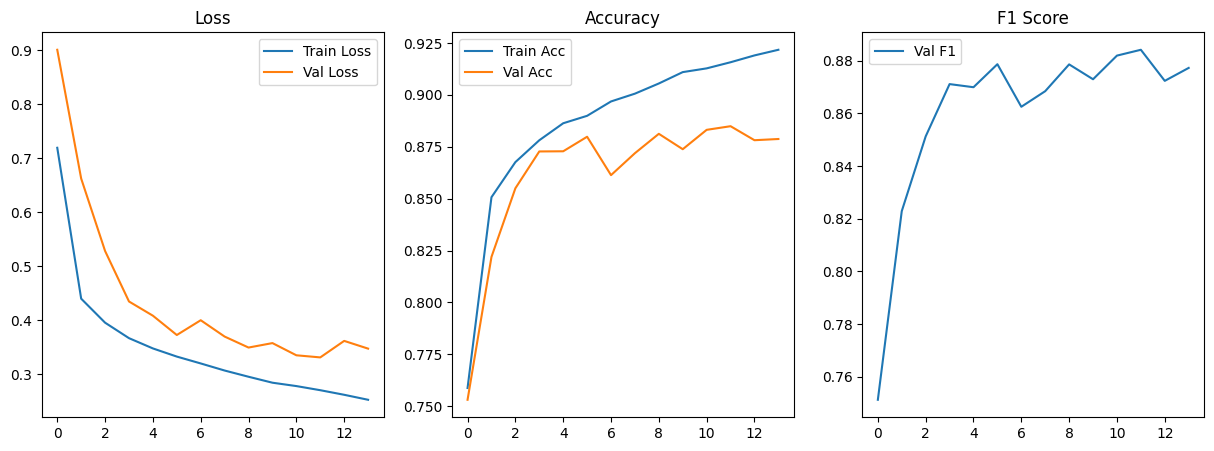

Test Accuracy: 0.8733
Test F1 Score: 0.8717


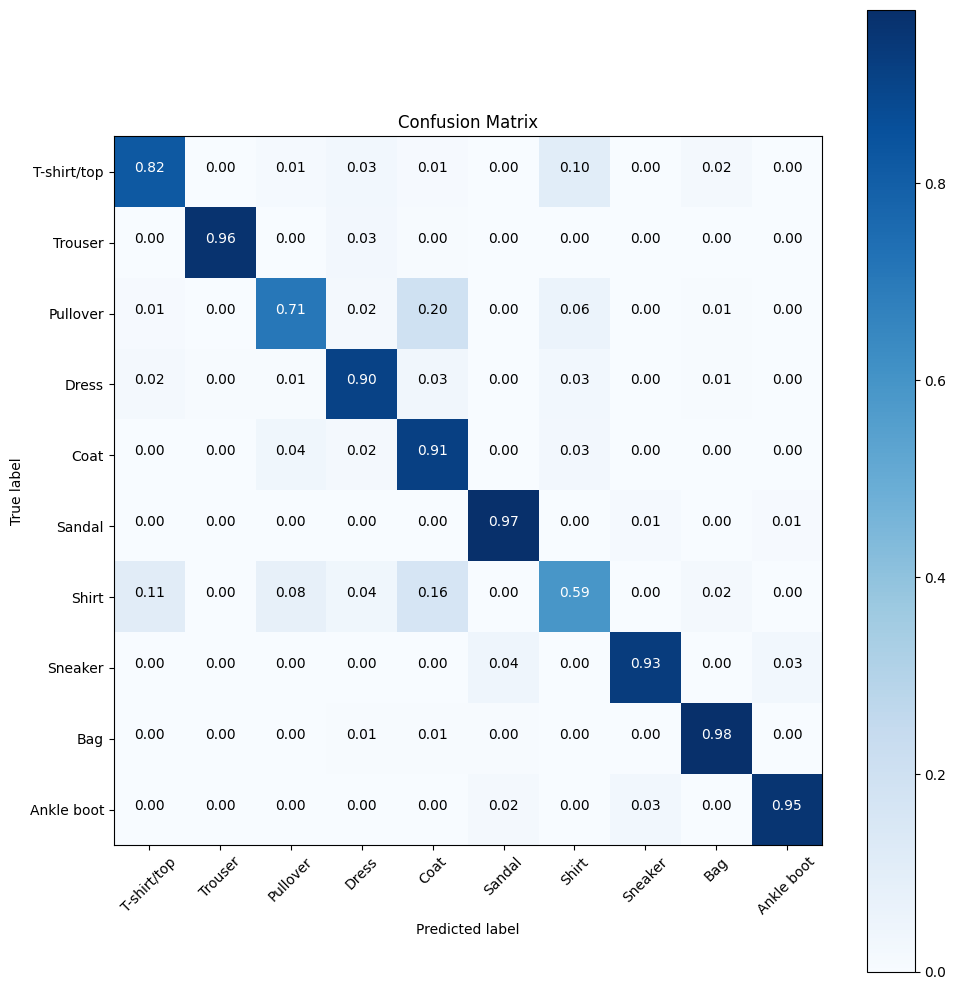

Classification report saved to ./reports/model_1_report_lr_0.000625.txt


In [68]:
for lr in learning_rates:
    run_diff_model('model_1',learning_rate=lr,dropout_rate=0.2,num_classes=10,num_epochs=15,batch_size=1024)

Running model_2 model with learning rate 0.005 and dropout rate 0.25
Epoch 1/15


100%|██████████| 46/46 [00:04<00:00, 10.27it/s]


Train Loss: 0.6587, Train Acc: 0.7772
Val Loss: 0.6692, Val Acc: 0.7816, Val F1: 0.7743
Epoch 2/15


100%|██████████| 46/46 [00:04<00:00, 10.48it/s]


Train Loss: 0.4351, Train Acc: 0.8521
Val Loss: 0.4510, Val Acc: 0.8458, Val F1: 0.8415
Epoch 3/15


100%|██████████| 46/46 [00:04<00:00, 10.78it/s]


Train Loss: 0.3938, Train Acc: 0.8651
Val Loss: 0.3992, Val Acc: 0.8639, Val F1: 0.8615
Epoch 4/15


100%|██████████| 46/46 [00:04<00:00, 10.58it/s]


Train Loss: 0.3683, Train Acc: 0.8735
Val Loss: 0.3665, Val Acc: 0.8711, Val F1: 0.8710
Epoch 5/15


100%|██████████| 46/46 [00:04<00:00,  9.65it/s]


Train Loss: 0.3464, Train Acc: 0.8849
Val Loss: 0.3789, Val Acc: 0.8693, Val F1: 0.8675
Epoch 6/15


100%|██████████| 46/46 [00:05<00:00,  9.07it/s]


Train Loss: 0.3343, Train Acc: 0.8896
Val Loss: 0.4157, Val Acc: 0.8573, Val F1: 0.8524
Early stopping at epoch 6


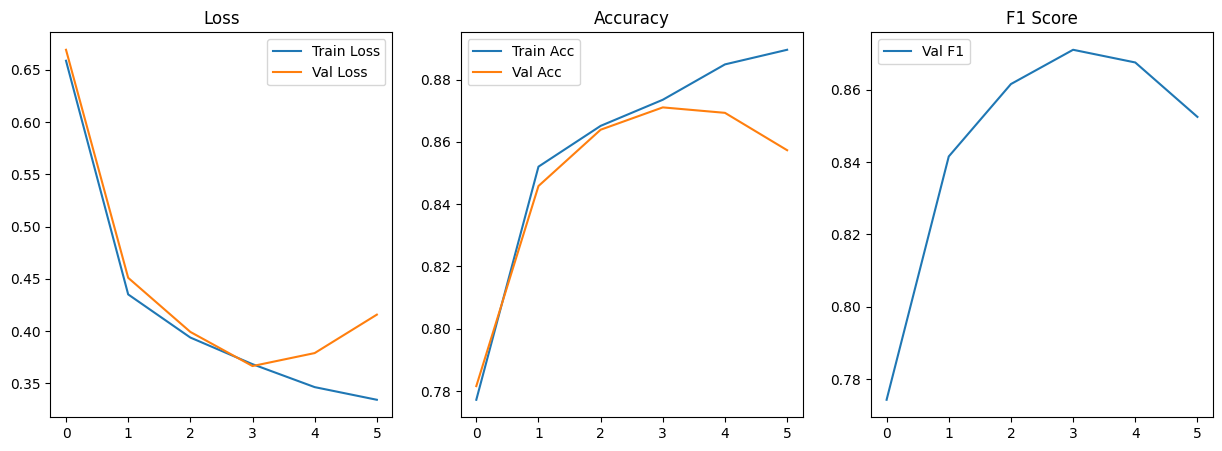

Test Accuracy: 0.8524
Test F1 Score: 0.8473


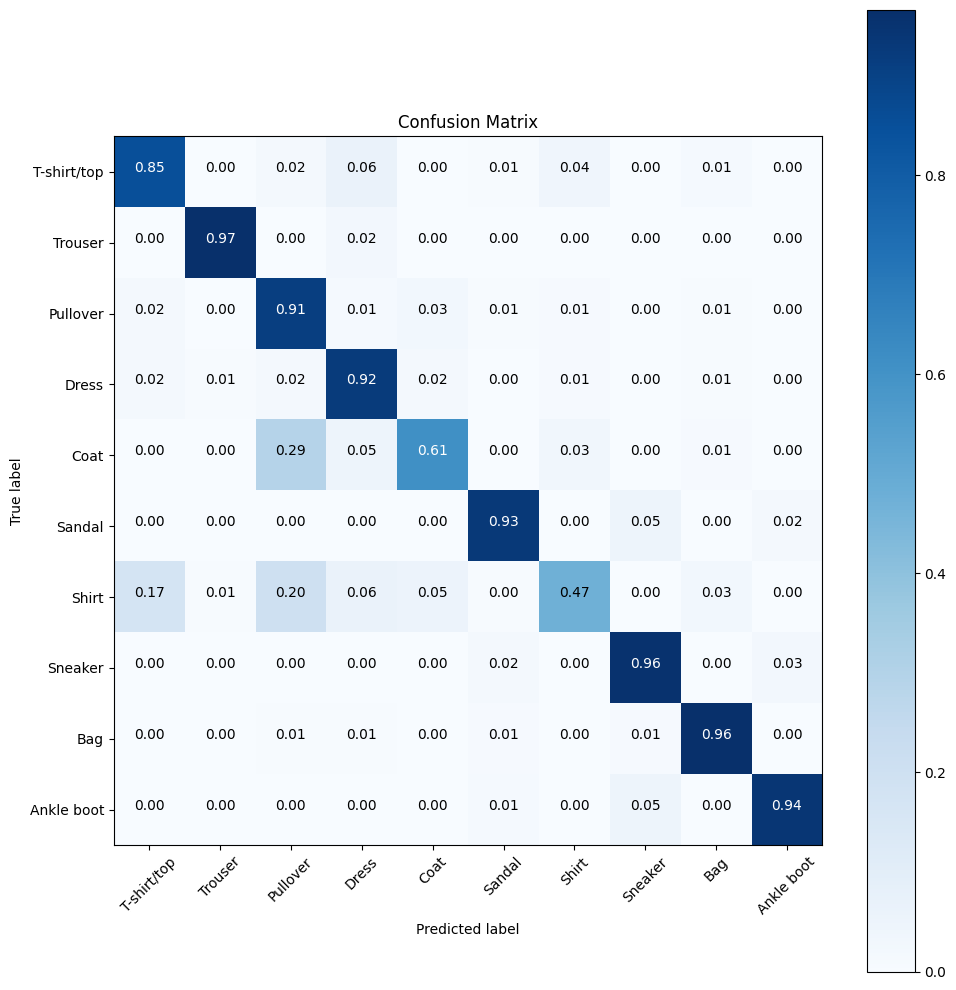

Classification report saved to ./reports/model_2_report_lr_0.005.txt
Running model_2 model with learning rate 0.0025 and dropout rate 0.25
Epoch 1/15


100%|██████████| 46/46 [00:04<00:00,  9.94it/s]


Train Loss: 0.6506, Train Acc: 0.7780
Val Loss: 0.7698, Val Acc: 0.7527, Val F1: 0.7287
Epoch 2/15


100%|██████████| 46/46 [00:04<00:00,  9.34it/s]


Train Loss: 0.4351, Train Acc: 0.8524
Val Loss: 0.4851, Val Acc: 0.8460, Val F1: 0.8447
Epoch 3/15


100%|██████████| 46/46 [00:04<00:00, 10.56it/s]


Train Loss: 0.3918, Train Acc: 0.8677
Val Loss: 0.4187, Val Acc: 0.8628, Val F1: 0.8621
Epoch 4/15


100%|██████████| 46/46 [00:04<00:00,  9.83it/s]


Train Loss: 0.3621, Train Acc: 0.8780
Val Loss: 0.3892, Val Acc: 0.8682, Val F1: 0.8669
Epoch 5/15


100%|██████████| 46/46 [00:04<00:00,  9.96it/s]


Train Loss: 0.3452, Train Acc: 0.8844
Val Loss: 0.3720, Val Acc: 0.8720, Val F1: 0.8716
Epoch 6/15


100%|██████████| 46/46 [00:04<00:00,  9.56it/s]


Train Loss: 0.3330, Train Acc: 0.8895
Val Loss: 0.3655, Val Acc: 0.8747, Val F1: 0.8732
Epoch 7/15


100%|██████████| 46/46 [00:05<00:00,  8.70it/s]


Train Loss: 0.3180, Train Acc: 0.8951
Val Loss: 0.3927, Val Acc: 0.8608, Val F1: 0.8589
Epoch 8/15


100%|██████████| 46/46 [00:04<00:00,  9.61it/s]


Train Loss: 0.3068, Train Acc: 0.8992
Val Loss: 0.3470, Val Acc: 0.8800, Val F1: 0.8787
Epoch 9/15


100%|██████████| 46/46 [00:04<00:00, 10.15it/s]


Train Loss: 0.2994, Train Acc: 0.9036
Val Loss: 0.3462, Val Acc: 0.8782, Val F1: 0.8777
Epoch 10/15


100%|██████████| 46/46 [00:04<00:00, 10.05it/s]


Train Loss: 0.2919, Train Acc: 0.9054
Val Loss: 0.3447, Val Acc: 0.8825, Val F1: 0.8821
Epoch 11/15


100%|██████████| 46/46 [00:04<00:00,  9.25it/s]


Train Loss: 0.2851, Train Acc: 0.9071
Val Loss: 0.3426, Val Acc: 0.8818, Val F1: 0.8803
Epoch 12/15


100%|██████████| 46/46 [00:04<00:00,  9.28it/s]


Train Loss: 0.2765, Train Acc: 0.9119
Val Loss: 0.3890, Val Acc: 0.8697, Val F1: 0.8628
Epoch 13/15


100%|██████████| 46/46 [00:04<00:00, 10.03it/s]


Train Loss: 0.2727, Train Acc: 0.9122
Val Loss: 0.3469, Val Acc: 0.8786, Val F1: 0.8787
Early stopping at epoch 13


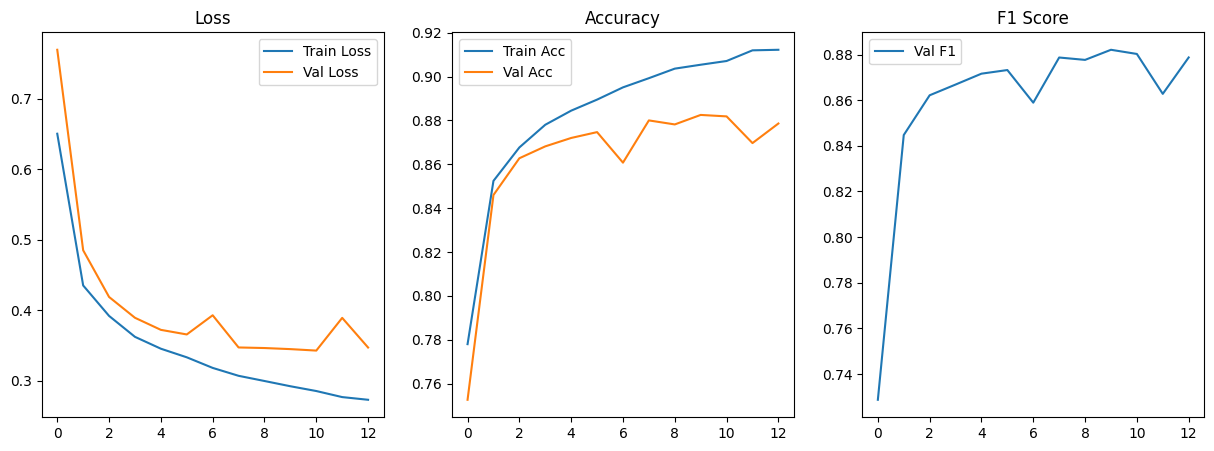

Test Accuracy: 0.8737
Test F1 Score: 0.8742


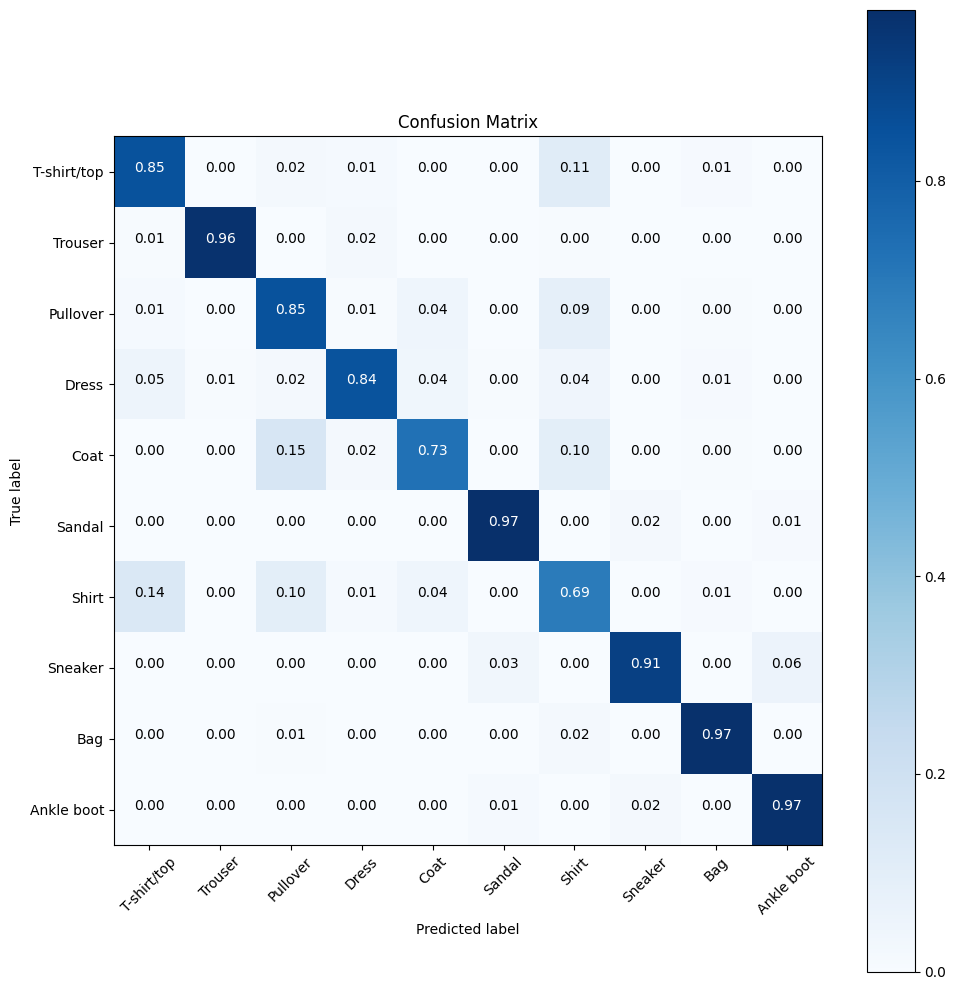

Classification report saved to ./reports/model_2_report_lr_0.0025.txt
Running model_2 model with learning rate 0.00125 and dropout rate 0.25
Epoch 1/15


100%|██████████| 46/46 [00:05<00:00,  8.63it/s]


Train Loss: 0.7381, Train Acc: 0.7498
Val Loss: 0.8125, Val Acc: 0.7570, Val F1: 0.7419
Epoch 2/15


100%|██████████| 46/46 [00:06<00:00,  6.94it/s]


Train Loss: 0.4560, Train Acc: 0.8452
Val Loss: 0.5747, Val Acc: 0.8406, Val F1: 0.8356
Epoch 3/15


100%|██████████| 46/46 [00:06<00:00,  6.92it/s]


Train Loss: 0.4080, Train Acc: 0.8631
Val Loss: 0.4915, Val Acc: 0.8542, Val F1: 0.8524
Epoch 4/15


100%|██████████| 46/46 [00:06<00:00,  6.95it/s]


Train Loss: 0.3819, Train Acc: 0.8725
Val Loss: 0.4170, Val Acc: 0.8632, Val F1: 0.8593
Epoch 5/15


100%|██████████| 46/46 [00:06<00:00,  7.65it/s]


Train Loss: 0.3629, Train Acc: 0.8798
Val Loss: 0.3929, Val Acc: 0.8732, Val F1: 0.8699
Epoch 6/15


100%|██████████| 46/46 [00:09<00:00,  4.95it/s]


Train Loss: 0.3471, Train Acc: 0.8861
Val Loss: 0.3783, Val Acc: 0.8712, Val F1: 0.8675
Epoch 7/15


100%|██████████| 46/46 [00:09<00:00,  4.96it/s]


Train Loss: 0.3326, Train Acc: 0.8925
Val Loss: 0.3807, Val Acc: 0.8661, Val F1: 0.8646
Epoch 8/15


100%|██████████| 46/46 [00:10<00:00,  4.31it/s]


Train Loss: 0.3243, Train Acc: 0.8946
Val Loss: 0.3906, Val Acc: 0.8682, Val F1: 0.8686
Early stopping at epoch 8


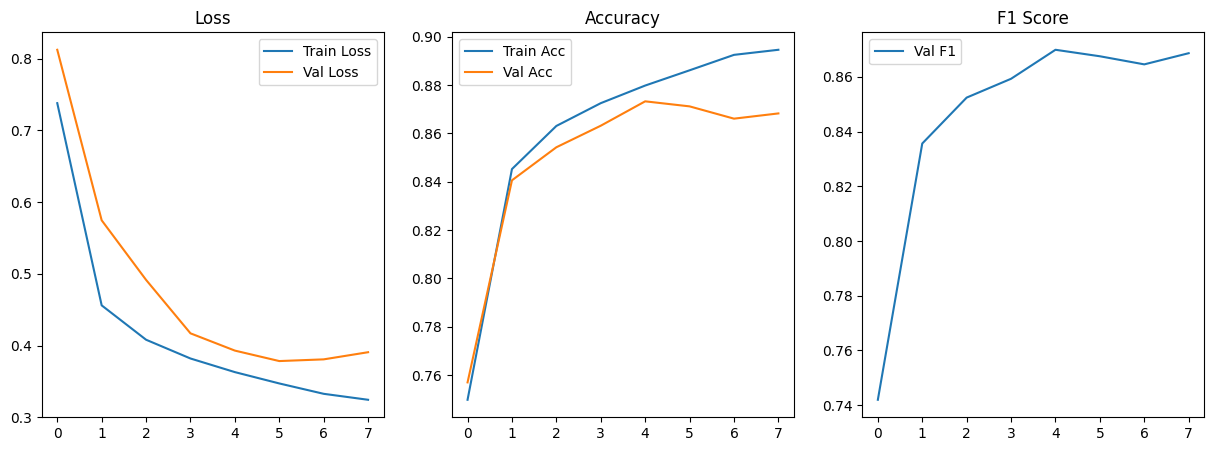

Test Accuracy: 0.8591
Test F1 Score: 0.8595


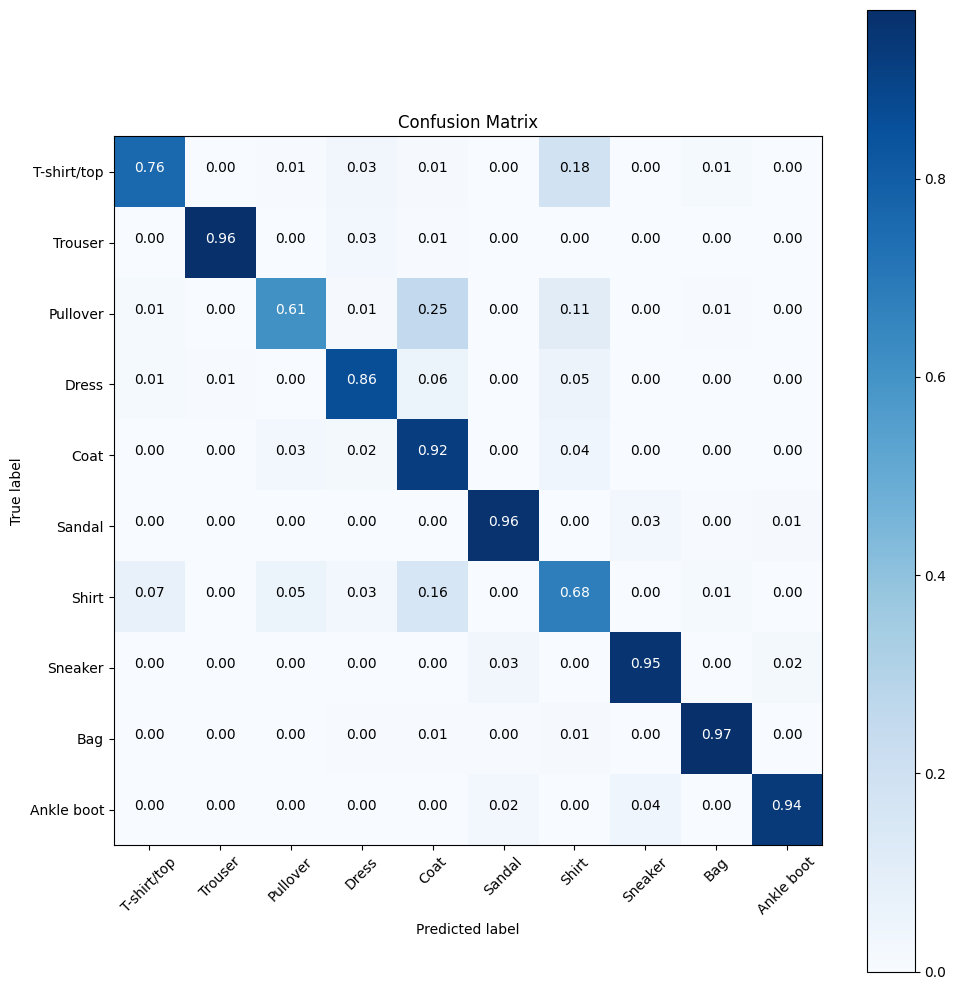

Classification report saved to ./reports/model_2_report_lr_0.00125.txt
Running model_2 model with learning rate 0.000625 and dropout rate 0.25
Epoch 1/15


100%|██████████| 46/46 [00:06<00:00,  7.10it/s]


Train Loss: 0.8592, Train Acc: 0.7104
Val Loss: 0.9698, Val Acc: 0.7369, Val F1: 0.7197
Epoch 2/15


100%|██████████| 46/46 [00:05<00:00,  7.84it/s]


Train Loss: 0.5033, Train Acc: 0.8295
Val Loss: 0.7028, Val Acc: 0.8277, Val F1: 0.8237
Epoch 3/15


100%|██████████| 46/46 [00:05<00:00,  8.53it/s]


Train Loss: 0.4483, Train Acc: 0.8491
Val Loss: 0.5562, Val Acc: 0.8471, Val F1: 0.8457
Epoch 4/15


100%|██████████| 46/46 [00:05<00:00,  8.37it/s]


Train Loss: 0.4134, Train Acc: 0.8635
Val Loss: 0.4767, Val Acc: 0.8584, Val F1: 0.8531
Epoch 5/15


100%|██████████| 46/46 [00:05<00:00,  9.12it/s]


Train Loss: 0.3900, Train Acc: 0.8708
Val Loss: 0.4249, Val Acc: 0.8621, Val F1: 0.8608
Epoch 6/15


100%|██████████| 46/46 [00:05<00:00,  8.11it/s]


Train Loss: 0.3778, Train Acc: 0.8766
Val Loss: 0.4090, Val Acc: 0.8640, Val F1: 0.8646
Epoch 7/15


100%|██████████| 46/46 [00:04<00:00,  9.46it/s]


Train Loss: 0.3620, Train Acc: 0.8809
Val Loss: 0.3820, Val Acc: 0.8727, Val F1: 0.8714
Epoch 8/15


100%|██████████| 46/46 [00:05<00:00,  8.99it/s]


Train Loss: 0.3506, Train Acc: 0.8864
Val Loss: 0.3845, Val Acc: 0.8646, Val F1: 0.8640
Epoch 9/15


100%|██████████| 46/46 [00:04<00:00,  9.78it/s]


Train Loss: 0.3389, Train Acc: 0.8904
Val Loss: 0.3620, Val Acc: 0.8771, Val F1: 0.8761
Epoch 10/15


100%|██████████| 46/46 [00:04<00:00,  9.78it/s]


Train Loss: 0.3319, Train Acc: 0.8925
Val Loss: 0.3568, Val Acc: 0.8765, Val F1: 0.8765
Epoch 11/15


100%|██████████| 46/46 [00:04<00:00,  9.54it/s]


Train Loss: 0.3223, Train Acc: 0.8959
Val Loss: 0.3516, Val Acc: 0.8795, Val F1: 0.8788
Epoch 12/15


100%|██████████| 46/46 [00:05<00:00,  9.05it/s]


Train Loss: 0.3137, Train Acc: 0.9006
Val Loss: 0.3542, Val Acc: 0.8775, Val F1: 0.8743
Epoch 13/15


100%|██████████| 46/46 [00:05<00:00,  9.07it/s]


Train Loss: 0.3076, Train Acc: 0.9021
Val Loss: 0.3455, Val Acc: 0.8834, Val F1: 0.8830
Epoch 14/15


100%|██████████| 46/46 [00:05<00:00,  8.74it/s]


Train Loss: 0.3036, Train Acc: 0.9039
Val Loss: 0.3442, Val Acc: 0.8808, Val F1: 0.8802
Epoch 15/15


100%|██████████| 46/46 [00:05<00:00,  8.78it/s]


Train Loss: 0.2931, Train Acc: 0.9075
Val Loss: 0.3327, Val Acc: 0.8854, Val F1: 0.8839


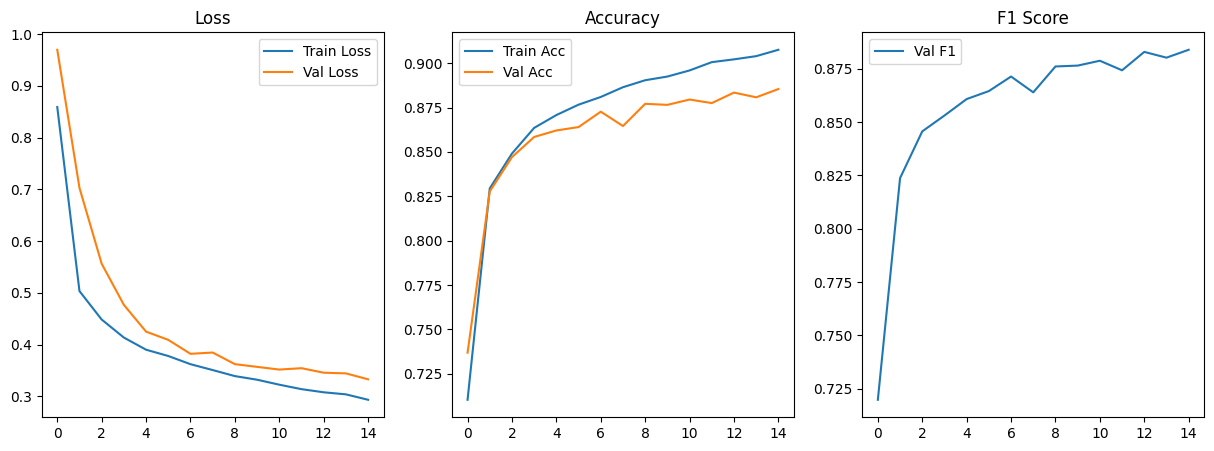

Test Accuracy: 0.8780
Test F1 Score: 0.8768


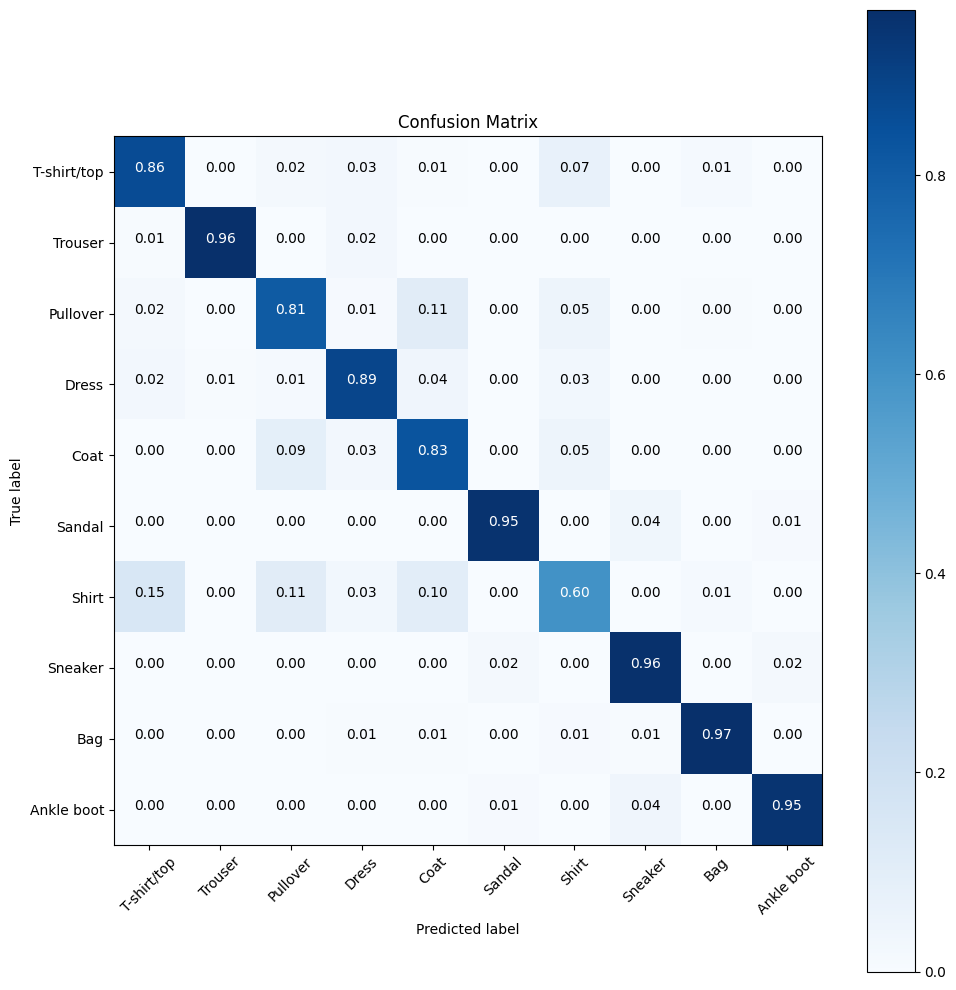

Classification report saved to ./reports/model_2_report_lr_0.000625.txt


In [69]:
for lr in learning_rates:
    run_diff_model('model_2',learning_rate=lr,dropout_rate=0.25,num_classes=10,num_epochs=15,batch_size=1024)

Running model_3 model with learning rate 0.005 and dropout rate 0.3
Epoch 1/15


100%|██████████| 46/46 [00:11<00:00,  3.84it/s]


Train Loss: 0.6825, Train Acc: 0.7718
Val Loss: 0.7071, Val Acc: 0.7891, Val F1: 0.7840
Epoch 2/15


100%|██████████| 46/46 [00:10<00:00,  4.40it/s]


Train Loss: 0.4322, Train Acc: 0.8518
Val Loss: 0.4855, Val Acc: 0.8429, Val F1: 0.8349
Epoch 3/15


100%|██████████| 46/46 [00:10<00:00,  4.22it/s]


Train Loss: 0.3851, Train Acc: 0.8674
Val Loss: 0.3867, Val Acc: 0.8667, Val F1: 0.8641
Epoch 4/15


100%|██████████| 46/46 [00:10<00:00,  4.43it/s]


Train Loss: 0.3669, Train Acc: 0.8745
Val Loss: 0.3681, Val Acc: 0.8733, Val F1: 0.8699
Epoch 5/15


100%|██████████| 46/46 [00:10<00:00,  4.39it/s]


Train Loss: 0.3421, Train Acc: 0.8829
Val Loss: 0.3606, Val Acc: 0.8742, Val F1: 0.8715
Epoch 6/15


100%|██████████| 46/46 [00:12<00:00,  3.82it/s]


Train Loss: 0.3312, Train Acc: 0.8883
Val Loss: 0.3954, Val Acc: 0.8678, Val F1: 0.8626
Epoch 7/15


100%|██████████| 46/46 [00:11<00:00,  3.95it/s]


Train Loss: 0.3213, Train Acc: 0.8921
Val Loss: 0.3609, Val Acc: 0.8788, Val F1: 0.8747
Early stopping at epoch 7


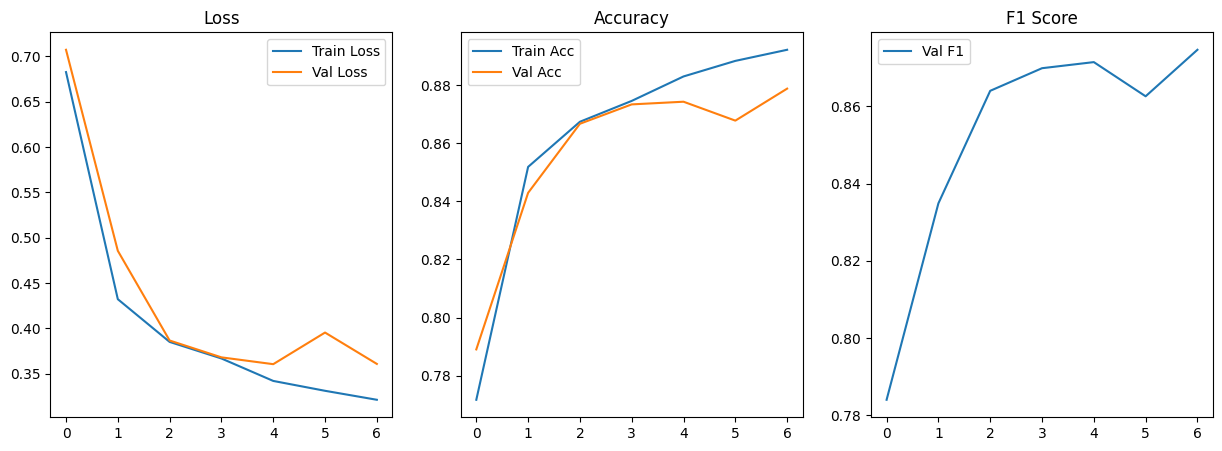

Test Accuracy: 0.8671
Test F1 Score: 0.8632


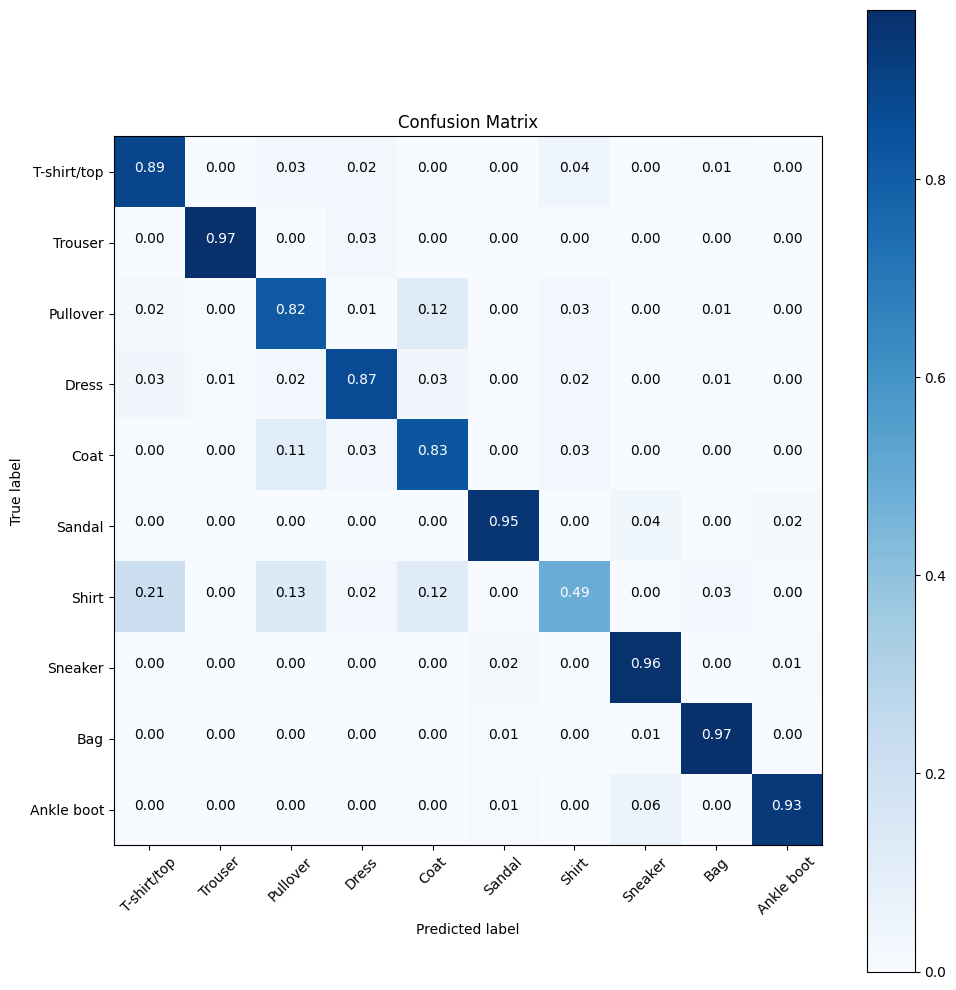

Classification report saved to ./reports/model_3_report_lr_0.005.txt
Running model_3 model with learning rate 0.0025 and dropout rate 0.3
Epoch 1/15


100%|██████████| 46/46 [00:12<00:00,  3.83it/s]


Train Loss: 0.7032, Train Acc: 0.7640
Val Loss: 0.6609, Val Acc: 0.7685, Val F1: 0.7460
Epoch 2/15


100%|██████████| 46/46 [00:12<00:00,  3.58it/s]


Train Loss: 0.4355, Train Acc: 0.8489
Val Loss: 0.4446, Val Acc: 0.8521, Val F1: 0.8477
Epoch 3/15


100%|██████████| 46/46 [00:13<00:00,  3.50it/s]


Train Loss: 0.3868, Train Acc: 0.8660
Val Loss: 0.4131, Val Acc: 0.8590, Val F1: 0.8523
Epoch 4/15


100%|██████████| 46/46 [00:13<00:00,  3.40it/s]


Train Loss: 0.3641, Train Acc: 0.8750
Val Loss: 0.4116, Val Acc: 0.8532, Val F1: 0.8478
Epoch 5/15


100%|██████████| 46/46 [00:12<00:00,  3.83it/s]


Train Loss: 0.3439, Train Acc: 0.8823
Val Loss: 0.3803, Val Acc: 0.8711, Val F1: 0.8693
Epoch 6/15


100%|██████████| 46/46 [00:11<00:00,  3.94it/s]


Train Loss: 0.3280, Train Acc: 0.8869
Val Loss: 0.3561, Val Acc: 0.8736, Val F1: 0.8750
Epoch 7/15


100%|██████████| 46/46 [00:12<00:00,  3.83it/s]


Train Loss: 0.3174, Train Acc: 0.8908
Val Loss: 0.3408, Val Acc: 0.8794, Val F1: 0.8779
Epoch 8/15


100%|██████████| 46/46 [00:11<00:00,  3.91it/s]


Train Loss: 0.3032, Train Acc: 0.8960
Val Loss: 0.3604, Val Acc: 0.8714, Val F1: 0.8719
Epoch 9/15


100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


Train Loss: 0.2943, Train Acc: 0.8987
Val Loss: 0.3926, Val Acc: 0.8674, Val F1: 0.8596
Early stopping at epoch 9


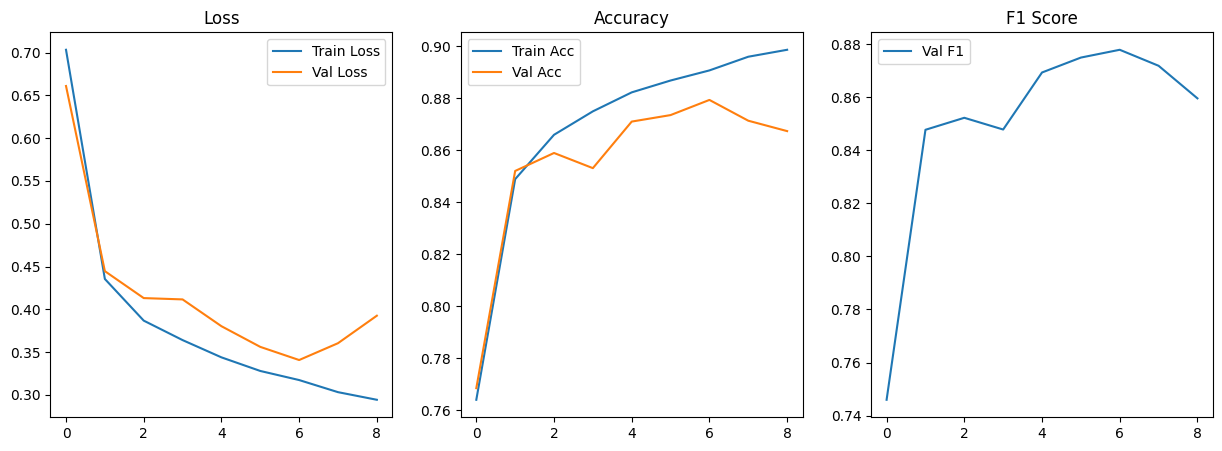

Test Accuracy: 0.8572
Test F1 Score: 0.8498


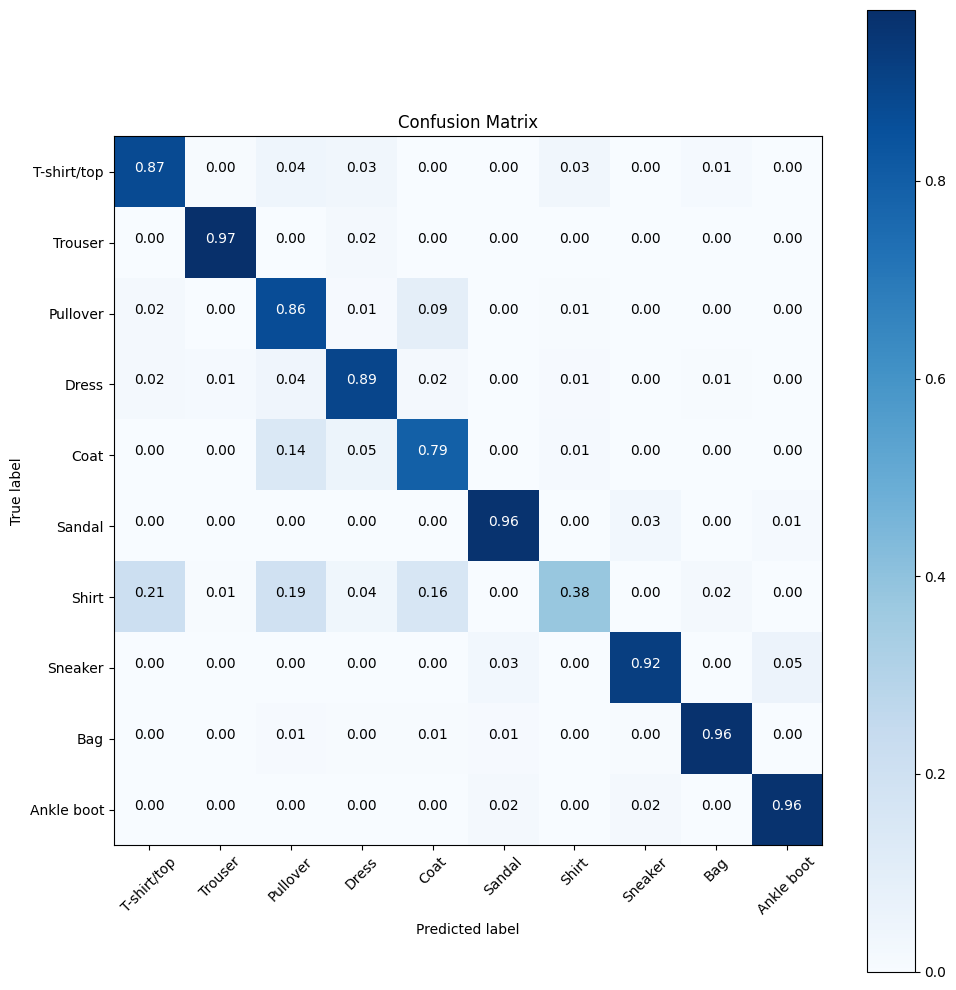

Classification report saved to ./reports/model_3_report_lr_0.0025.txt
Running model_3 model with learning rate 0.00125 and dropout rate 0.3
Epoch 1/15


100%|██████████| 46/46 [00:11<00:00,  4.00it/s]


Train Loss: 0.7010, Train Acc: 0.7660
Val Loss: 0.7627, Val Acc: 0.7863, Val F1: 0.7752
Epoch 2/15


100%|██████████| 46/46 [00:11<00:00,  3.85it/s]


Train Loss: 0.4395, Train Acc: 0.8517
Val Loss: 0.4781, Val Acc: 0.8533, Val F1: 0.8526
Epoch 3/15


100%|██████████| 46/46 [00:12<00:00,  3.78it/s]


Train Loss: 0.3921, Train Acc: 0.8661
Val Loss: 0.4154, Val Acc: 0.8692, Val F1: 0.8682
Epoch 4/15


100%|██████████| 46/46 [00:10<00:00,  4.27it/s]


Train Loss: 0.3658, Train Acc: 0.8740
Val Loss: 0.3851, Val Acc: 0.8713, Val F1: 0.8683
Epoch 5/15


100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


Train Loss: 0.3449, Train Acc: 0.8820
Val Loss: 0.4080, Val Acc: 0.8573, Val F1: 0.8523
Epoch 6/15


100%|██████████| 46/46 [00:13<00:00,  3.52it/s]


Train Loss: 0.3338, Train Acc: 0.8866
Val Loss: 0.3351, Val Acc: 0.8834, Val F1: 0.8839
Epoch 7/15


100%|██████████| 46/46 [00:16<00:00,  2.72it/s]


Train Loss: 0.3175, Train Acc: 0.8932
Val Loss: 0.3554, Val Acc: 0.8743, Val F1: 0.8749
Epoch 8/15


100%|██████████| 46/46 [00:12<00:00,  3.62it/s]


Train Loss: 0.3083, Train Acc: 0.8958
Val Loss: 0.3707, Val Acc: 0.8696, Val F1: 0.8661
Early stopping at epoch 8


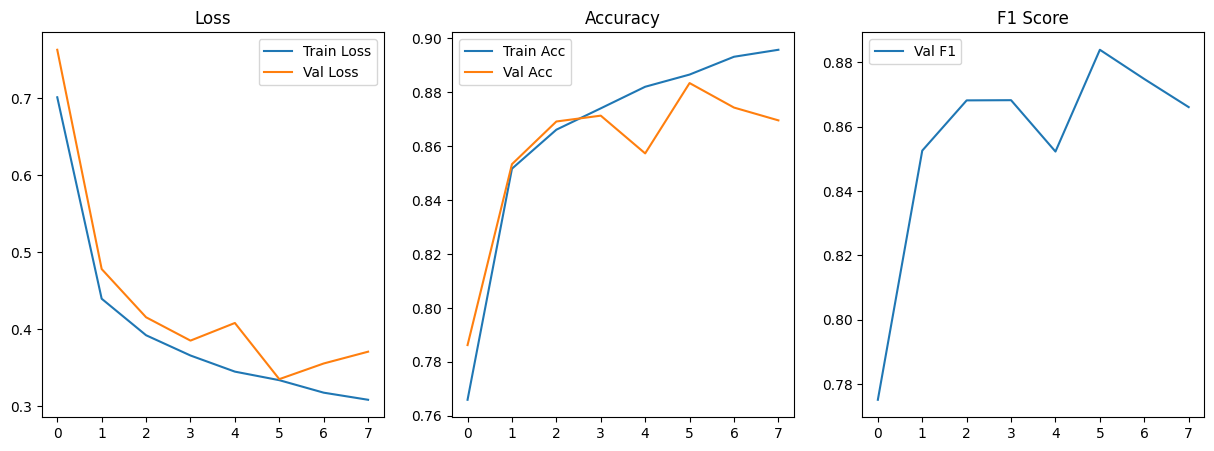

Test Accuracy: 0.8600
Test F1 Score: 0.8571


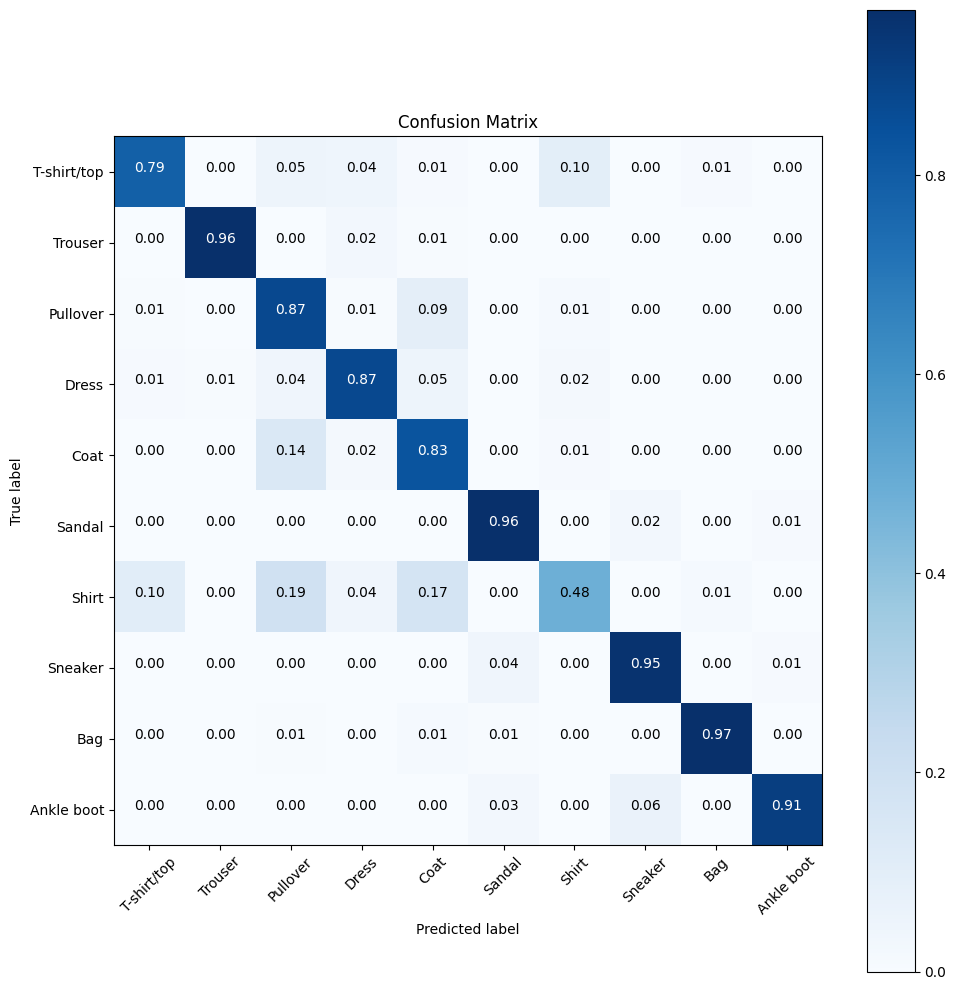

Classification report saved to ./reports/model_3_report_lr_0.00125.txt
Running model_3 model with learning rate 0.000625 and dropout rate 0.3
Epoch 1/15


100%|██████████| 46/46 [00:12<00:00,  3.78it/s]


Train Loss: 0.7976, Train Acc: 0.7359
Val Loss: 0.9460, Val Acc: 0.7765, Val F1: 0.7678
Epoch 2/15


100%|██████████| 46/46 [00:14<00:00,  3.22it/s]


Train Loss: 0.4773, Train Acc: 0.8389
Val Loss: 0.6301, Val Acc: 0.8466, Val F1: 0.8447
Epoch 3/15


100%|██████████| 46/46 [00:11<00:00,  3.94it/s]


Train Loss: 0.4180, Train Acc: 0.8575
Val Loss: 0.4725, Val Acc: 0.8608, Val F1: 0.8581
Epoch 4/15


100%|██████████| 46/46 [00:11<00:00,  4.02it/s]


Train Loss: 0.3895, Train Acc: 0.8687
Val Loss: 0.4204, Val Acc: 0.8694, Val F1: 0.8673
Epoch 5/15


100%|██████████| 46/46 [00:11<00:00,  3.95it/s]


Train Loss: 0.3690, Train Acc: 0.8747
Val Loss: 0.3694, Val Acc: 0.8773, Val F1: 0.8774
Epoch 6/15


100%|██████████| 46/46 [00:12<00:00,  3.82it/s]


Train Loss: 0.3550, Train Acc: 0.8806
Val Loss: 0.3521, Val Acc: 0.8800, Val F1: 0.8781
Epoch 7/15


100%|██████████| 46/46 [00:16<00:00,  2.81it/s]


Train Loss: 0.3420, Train Acc: 0.8842
Val Loss: 0.3571, Val Acc: 0.8788, Val F1: 0.8746
Epoch 8/15


100%|██████████| 46/46 [00:14<00:00,  3.17it/s]


Train Loss: 0.3287, Train Acc: 0.8901
Val Loss: 0.3421, Val Acc: 0.8798, Val F1: 0.8782
Epoch 9/15


100%|██████████| 46/46 [00:12<00:00,  3.58it/s]


Train Loss: 0.3155, Train Acc: 0.8950
Val Loss: 0.3301, Val Acc: 0.8856, Val F1: 0.8843
Epoch 10/15


100%|██████████| 46/46 [00:14<00:00,  3.21it/s]


Train Loss: 0.3103, Train Acc: 0.8963
Val Loss: 0.3397, Val Acc: 0.8798, Val F1: 0.8761
Epoch 11/15


100%|██████████| 46/46 [00:11<00:00,  3.95it/s]


Train Loss: 0.2996, Train Acc: 0.8997
Val Loss: 0.3306, Val Acc: 0.8862, Val F1: 0.8851
Early stopping at epoch 11


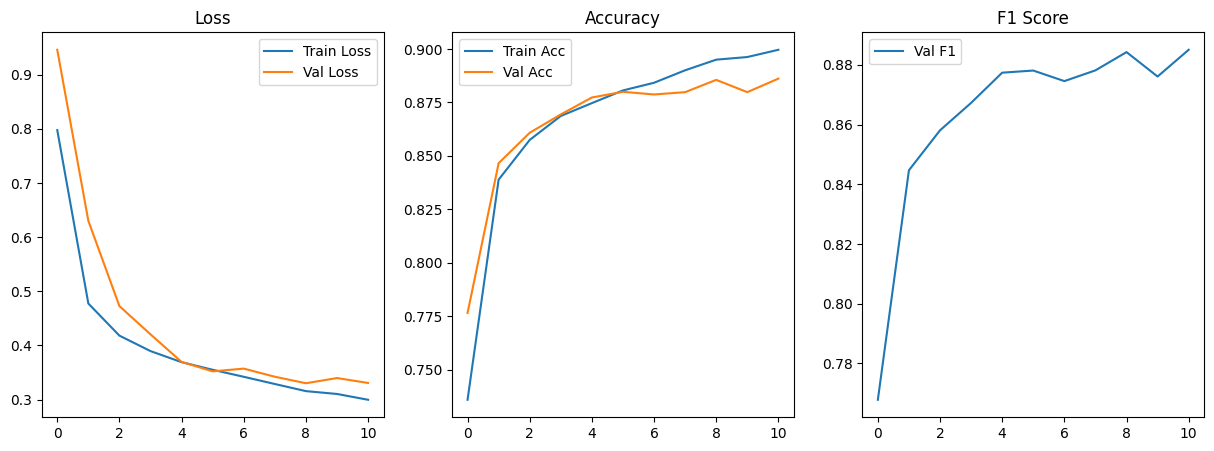

Test Accuracy: 0.8735
Test F1 Score: 0.8723


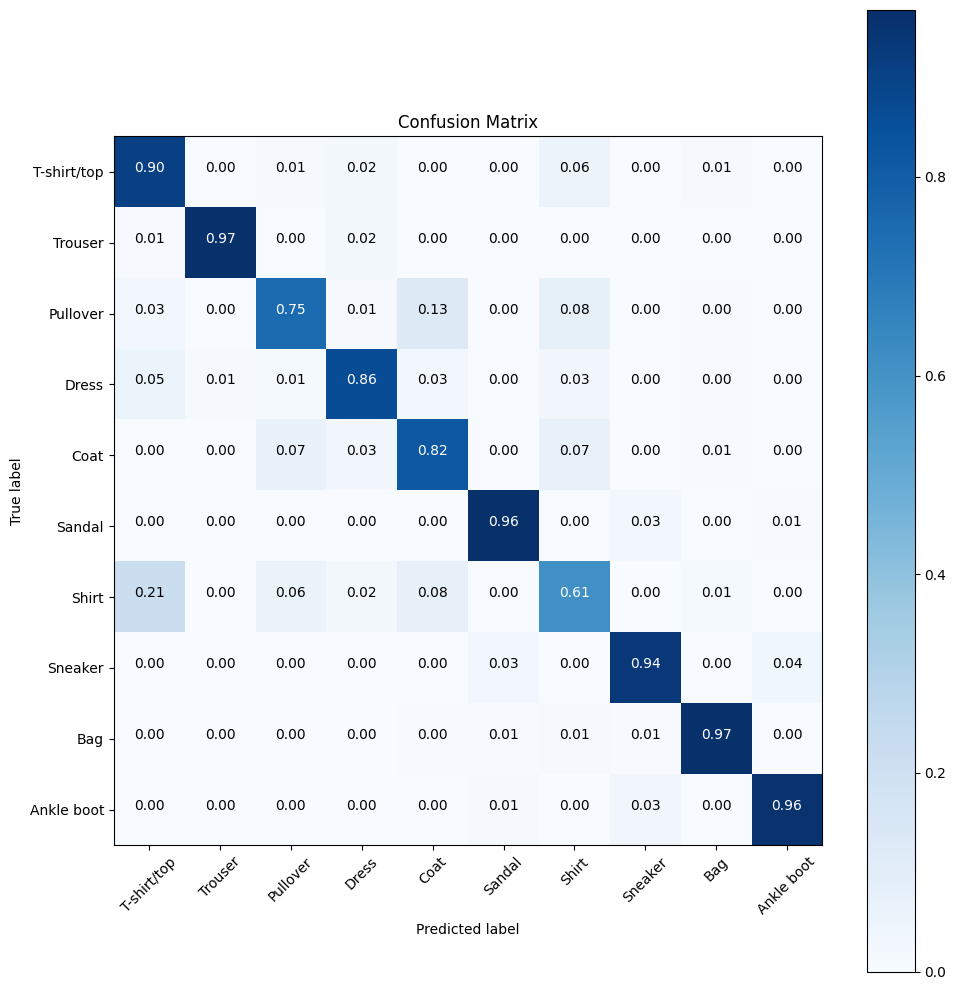

Classification report saved to ./reports/model_3_report_lr_0.000625.txt


In [70]:
for lr in learning_rates:
    run_diff_model('model_3',learning_rate=lr,dropout_rate=0.3,num_classes=10,num_epochs=15,batch_size=1024)

# Testing block for saved model

In [516]:
# load the model from the pickle file and test it
# the pickle file only contains the weights and biases of the model
final_model_arch = create_model_1()
# print(final_model_arch)
final_model = NeuralNetwork.load('./models/model_1_lr_0.00125.pkl', model=final_model_arch)
# print(final_model)
X_train, y_train, X_test, y_test = load_fashion_mnist()

y_pred = final_model.predict(X_test)
test_acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

{'weights': {'DenseLayer_0_weights': array([[ 0.126417  ,  0.08931155,  0.02143913, ..., -0.01564264,
         0.0185253 , -0.04916851],
       [ 0.03869223, -0.029568  ,  0.02946379, ...,  0.00080168,
        -0.02091733, -0.04223702],
       [-0.03080516, -0.02662664,  0.03105046, ..., -0.05858687,
        -0.09652298, -0.01975744],
       ...,
       [-0.05192466, -0.01222589, -0.02678459, ..., -0.04881703,
         0.01812986, -0.01933007],
       [-0.01480636, -0.00633037,  0.03577592, ...,  0.06923421,
         0.04447077, -0.02761678],
       [ 0.00702047,  0.0357105 ,  0.0766769 , ..., -0.01265645,
        -0.03287189, -0.07831307]]), 'DenseLayer_4_weights': array([[ 0.09530928,  0.04503999,  0.10852722, ...,  0.02404214,
        -0.06522931, -0.04775918],
       [ 0.11534001,  0.00939567,  0.15027515, ...,  0.02424826,
        -0.00031757, -0.01754077],
       [ 0.15989618,  0.08594342,  0.17499045, ...,  0.09097377,
        -0.09078065, -0.02997655],
       ...,
       [-0.04